In [1]:
import torch
import torch.nn as nn
from torch.autograd import grad
import pandas as pd
from InverseFuncs import trajectory, getLoss, reset_theta, theta_range

from DDPGv2Agent import Agent
from FireflyEnv import Model # firefly_task.py
from collections import deque
from Inverse_Config import Inverse_Config
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# read configuration parameters
arg = Inverse_Config()

# fix random seed
import random
random.seed(arg.SEED_NUMBER)
import torch
torch.manual_seed(arg.SEED_NUMBER)
if torch.cuda.is_available():
    torch.cuda.manual_seed(arg.SEED_NUMBER)
import numpy as np
np.random.seed(arg.SEED_NUMBER)
import time

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

num_cores = multiprocessing.cpu_count()
print("{} cores are available".format(num_cores))

# if gpu is to be used
#CUDA = False
#device = "cpu"

CUDA = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tic = time.time()



filename = '20191231-172726-01081157' # agent information

learning_arg = torch.load('../firefly-inverse-data/data/20191231-172726_arg.pkl')

DISCOUNT_FACTOR = learning_arg.DISCOUNT_FACTOR
arg.gains_range = learning_arg.gains_range
arg.std_range = learning_arg.std_range
arg.goal_radius_range = learning_arg.goal_radius_range
arg.WORLD_SIZE = learning_arg.WORLD_SIZE
arg.DELTA_T = learning_arg.DELTA_T
arg.EPISODE_TIME = learning_arg.EPISODE_TIME
arg.EPISODE_LEN = learning_arg.EPISODE_LEN
arg.PI_STD = 0.1
arg.NUM_EP = 500
arg.NUM_SAMPLES =50


env = Model(arg) # build an environment
env.max_goal_radius = arg.goal_radius_range[1] # use the largest world size for goal radius
env.box = arg.WORLD_SIZE
agent = Agent(env.state_dim, env.action_dim, arg,  filename, hidden_dim=128, gamma=DISCOUNT_FACTOR, tau=0.001) #, device = "cpu")
agent.load(filename)


12 cores are available
Running DDPG Agent: using  cpu


In [2]:
arg.PI_STD

0.1

In [3]:
arg.NUM_EP

500

In [4]:
arg.NUM_SAMPLES

50

In [5]:
def loss_cal(vel, proc_std_vel, std_space, true_theta):
    
    loss_log = torch.zeros(len(std_space)+1)
    pro_gains = torch.zeros(2)
    pro_noise_stds = torch.zeros(2)
    obs_gains = torch.zeros(2)
    obs_noise_stds = torch.zeros(2)
    goal_radius = torch.zeros(1)
    
    theta_log = []
    inputs_ang = np.sort(np.append(std_space, true_theta[3]))

    pro_noise_stds[0] = proc_std_vel
    for ang, pro_std_ang in enumerate(tqdm(inputs_ang)):
        pro_noise_stds[1] = proc_std_ang
    
        for pro_gains_vel  in [true_theta[0]]:#np.append(gain_space, true_theta[4]):
            pro_gains[0] = pro_gains_vel
            for pro_gains_ang in [true_theta[1]]:#np.append(gain_space, true_theta[5]):
                pro_gains[1] = pro_gains_ang
                for obs_gains_vel  in [true_theta[4]]:
                    obs_gains[0] = obs_gains_vel
                    for obs_gains_ang  in [true_theta[5]]:
                        obs_gains[1] = obs_gains_ang
                        for obs_std_vel in [true_theta[6]]:#np.append(std_space, true_theta[6]):
                            obs_noise_stds[0] = obs_std_vel 
                            for obs_std_ang in [true_theta[7]]:#np.append(std_space, true_theta[7]):
                                obs_noise_stds[1] = obs_std_ang
                                for goal_r in [true_theta[8]]: #np.append(goal_radius_space, true_theta[8]):
                                    goal_radius[0] = goal_r
                                    
                                    
                                    theta = torch.cat([pro_gains, pro_noise_stds, obs_gains, obs_noise_stds, goal_radius])
    
    
                                    theta_log.append(theta.data)
                                    loss = getLoss(agent, x_traj, a_traj, theta, env, arg.gains_range, arg.std_range, arg.PI_STD, arg.NUM_SAMPLES)
                                    loss_log[ang] = loss.data
                                    #loss_log.append(loss.data)

                                    print("num:{}, theta:{}, loss:{}".format(vel, theta, loss))
                        
                        
    """
    result = {'true_theta': true_theta,
         'true_loss': true_loss,
         'theta_log': theta_log,
         'loss_log': loss_log}
    """
    return loss_log


In [4]:
# true theta
#true_theta = reset_theta(arg.gains_range, arg.std_range, arg.goal_radius_range)
#true_theta[4]=8.5
#true_theta[5]=10.5
true_theta=torch.tensor([11.4042,  8.6168,  0.2885,  0.9043, 11.1173,  8.1504,  1.7711,  0.1619,0.2809])


x_traj, obs_traj, a_traj, _ = trajectory(agent, true_theta, env, arg, arg.gains_range, arg.std_range,arg.goal_radius_range, arg.NUM_EP)  # generate true trajectory
true_loss = getLoss(agent, x_traj, a_traj, true_theta, env, arg.gains_range, arg.std_range, arg.PI_STD, arg.NUM_SAMPLES)  # this is the lower bound of loss?
print("true loss:{}".format(true_loss))
print("true_theta:{}".format(true_theta))

current_theta = true_theta

KeyboardInterrupt: 

In [5]:
#gain_space = np.linspace(arg.gains_range[0],arg.gains_range[1], num = 3)
std_space = np.linspace(arg.std_range[0], arg.std_range[1], num = 9)
#goal_radius_space = np.linspace(arg.goal_radius_range[0], arg.goal_radius_range[1], num =3)

In [6]:
std_space

array([0.01 , 1.005, 2.   ])

In [9]:
true_theta


tensor([11.4042,  8.6168,  0.2885,  0.9043, 11.1173,  8.1504,  1.7711,  0.1619,
         0.2809])

In [10]:
current_theta=torch.tensor([11.4042,  8.6168, 0.2885,  0.9043, 11.1173,  8.1504,
        1.7711,  0.1619, 0.2809])

In [11]:
inputs_vel = np.sort(np.append(std_space, true_theta[2]))
inputs_ang = np.sort(np.append(std_space, true_theta[3]))
#loss_log = torch.zeros([len(gain_space)+1, len(gain_space)+1])
loss_log = Parallel(n_jobs=num_cores)(delayed(loss_cal)(vel, proc_std_vel, std_space, current_theta) for vel, proc_std_vel in enumerate(inputs_vel))

"""
for vel, pro_gains_vel in enumerate(inputs): 
    result_log = loss_cal(vel, pro_gains_vel, gain_space, true_theta) 
"""

'\nfor vel, pro_gains_vel in enumerate(inputs): \n    result_log = loss_cal(vel, pro_gains_vel, gain_space, true_theta) \n'

In [12]:
loss_log   

[tensor([708034.7500, 707910.5000, 708061.2500, 708193.8125, 708355.3750,
         707860.2500, 707711.6875, 707918.2500, 708009.1250, 708207.8750]),
 tensor([707940.4375, 708229.0000, 708318.5625, 708629.8750, 708124.3750,
         707812.4375, 708073.2500, 707822.7500, 708029.2500, 707828.6875]),
 tensor([708327.8125, 707901.6250, 708301.7500, 708147.8750, 707840.1875,
         708328.6875, 708281.8750, 707995.6875, 708115.8125, 708133.6875]),
 tensor([708162.2500, 708146.7500, 707738.4375, 708160.1250, 708095.1875,
         707839.4375, 707694.3750, 708418.6875, 708267.0625, 708391.1250]),
 tensor([707730.5000, 707986.9375, 707873.5000, 708075.5625, 708248.1875,
         707911.4375, 708094.2500, 707644.1250, 708246.8125, 708207.0625]),
 tensor([707906.1250, 707960.8750, 707951.5000, 708092.2500, 708443.8125,
         708123.5000, 707753.1875, 708223.5000, 708077.4375, 708303.0625]),
 tensor([708064.6875, 708025.8125, 708390.5000, 708098.0625, 707698.9375,
         708175.6875, 7075

In [13]:
loss_log_tot = torch.cat([loss_log[i] for i in range (len(loss_log))])

In [14]:
loss_log_tot

tensor([708034.7500, 707910.5000, 708061.2500, 708193.8125, 708355.3750,
        707860.2500, 707711.6875, 707918.2500, 708009.1250, 708207.8750,
        707940.4375, 708229.0000, 708318.5625, 708629.8750, 708124.3750,
        707812.4375, 708073.2500, 707822.7500, 708029.2500, 707828.6875,
        708327.8125, 707901.6250, 708301.7500, 708147.8750, 707840.1875,
        708328.6875, 708281.8750, 707995.6875, 708115.8125, 708133.6875,
        708162.2500, 708146.7500, 707738.4375, 708160.1250, 708095.1875,
        707839.4375, 707694.3750, 708418.6875, 708267.0625, 708391.1250,
        707730.5000, 707986.9375, 707873.5000, 708075.5625, 708248.1875,
        707911.4375, 708094.2500, 707644.1250, 708246.8125, 708207.0625,
        707906.1250, 707960.8750, 707951.5000, 708092.2500, 708443.8125,
        708123.5000, 707753.1875, 708223.5000, 708077.4375, 708303.0625,
        708064.6875, 708025.8125, 708390.5000, 708098.0625, 707698.9375,
        708175.6875, 707553.0000, 708403.3750, 7075

In [15]:
loss_log_tot.min()

tensor(707553.)

In [16]:
true_theta

tensor([11.4042,  8.6168,  0.2885,  0.9043, 11.1173,  8.1504,  1.7711,  0.1619,
         0.2809])

In [17]:
dx, dy = 0.25, 0.25
new_std_space = np.append(std_space, std_space.max()+0.1)

pinputs_vel = np.sort(np.append(new_std_space, true_theta[2]))
pinputs_ang = np.sort(np.append(new_std_space, true_theta[3]))
x,y = np.meshgrid( pinputs_ang-dy, pinputs_vel-dx)
Z = loss_log_tot

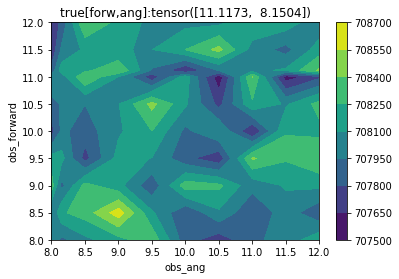

In [18]:
plt.contourf(inputs_ang, inputs_vel,Z.view(len(inputs_vel), len(inputs_ang)))  
plt.xlabel('proc_std_ang')
plt.ylabel('proc_std_fwd')
plt.title('true[forw,ang]:{}'.format(true_theta[2:4].data))
plt.colorbar()

In [19]:
new_gain_space

array([ 8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5])

Text(0.5, 1.0, 'true[forw,ang]:tensor([11.1173,  8.1504])')

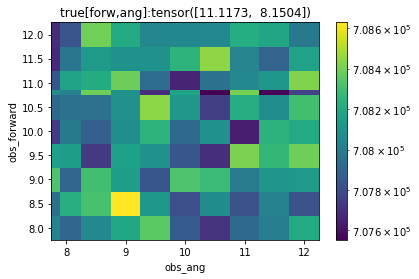

In [20]:

plt.pcolor(x, y, Z.view(len(inputs_vel), len(inputs_ang)), norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()))
plt.colorbar()
plt.xlabel('proc_std_ang')
plt.ylabel('proc_std_fwd')
plt.title('true[forw,ang]:{}'.format(true_theta[2:4].data))


In [21]:
torch.save(loss_log, '../firefly-inverse-data/data/'+filename+'loss_proc_std_plotter.pkl')